<table align="left"><td>
  <a target="_blank"  href="https://github.com/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

In [1]:
import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import json
import os
from imutils import paths
import cv2

In [2]:
Base_Path = "/media/beast/Samsung_T5/nVidia_Research_Work"

## DATA IN FORMAT
 Base_Path<br>
&emsp;&emsp;|-train2017<br>
&emsp;&emsp;|-val2017<br>
&emsp;&emsp;|-annotations_val(without_column_names).csv<br>
&emsp;&emsp;|-annotations_train(without_column_names).csv<br>

for csv files  first run "Preparing_Dataset.ipynb"

In [3]:
Train_Images_Path = os.path.sep.join([Base_Path, 'train2017'])
Val_Images_Path = os.path.sep.join([Base_Path, 'val2017'])
Annots_Val_Path = os.path.sep.join([Base_Path, 'annotations_val(without_column_names).csv'])
Annots_Train_Path = os.path.sep.join([Base_Path, 'annotations_train(without_column_names).csv'])
# Lb_Path = os.path.sep.join([Base_Path, 'lb.pickle'])

## Setting Up training data

In [ ]:
print("[INFO] loading dataset....")
data_train = []
# labels_train = []
# bboxes_train = []
# image_Paths_train = []
rows = open(Annots_Train_Path).read().strip().split("\n")
for row in rows:
    row = row.split(",")
    (filename, startX, startY, endX, endY, cat_ID, cat_Name) = row
    imagePath = os.path.sep.join([Train_Images_Path, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    image = load_img(imagePath, target_size = (512,512))
    image = img_to_array(image)
    data_train.append(image)
#     labels_train.append(cat_Name)
#     bboxes_train.append((startX, startY, endX, endY))
#     image_Paths_train.append(imagePath)
    print(len(data_train))

## Setting up validation data

In [ ]:
print("[INFO] loading dataset....")
data_val = []
# labels_train = []
# bboxes_train = []
# image_Paths_train = []
rows = open(Annots_Val_Path).read().strip().split("\n")
for row in rows:
    row = row.split(",")
    (filename, startX, startY, endX, endY, cat_ID, cat_Name) = row
    imagePath = os.path.sep.join([Val_Images_Path, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    image = load_img(imagePath, target_size = (512,512))
    image = img_to_array(image)
    data_val.append(image)
#     labels_train.append(cat_Name)
#     bboxes_train.append((startX, startY, endX, endY))
#     image_Paths_train.append(imagePath)
    print(len(data_val))

## Saving variables to prevent loading data again and again

In [ ]:
# import dill
# dill.dump_session('autoencoder_variables.db')
# dill.load_session('autoencoder_variables.db')

converting images into numpy array

In [ ]:
data = np.array(data_train, dtype="float32") / 255.0
(val_images) = np.array(data_val, dtype="float32") / 255.0
# labels = np.array(labels)
# bboxes = np.array(bboxes, dtype = "float32")
# image_Paths = np.array(image_Paths)

In [ ]:
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)

## splitting dataset

In [ ]:
(train_images, test_images) = train_test_split(data, test_size=0.10, random_state = 42)

## Preparing autoencoder

In [4]:
input_img = Input(shape=(512,512,3))
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2), padding='same')(x)

##################################################################

x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
autoencoder.summary()

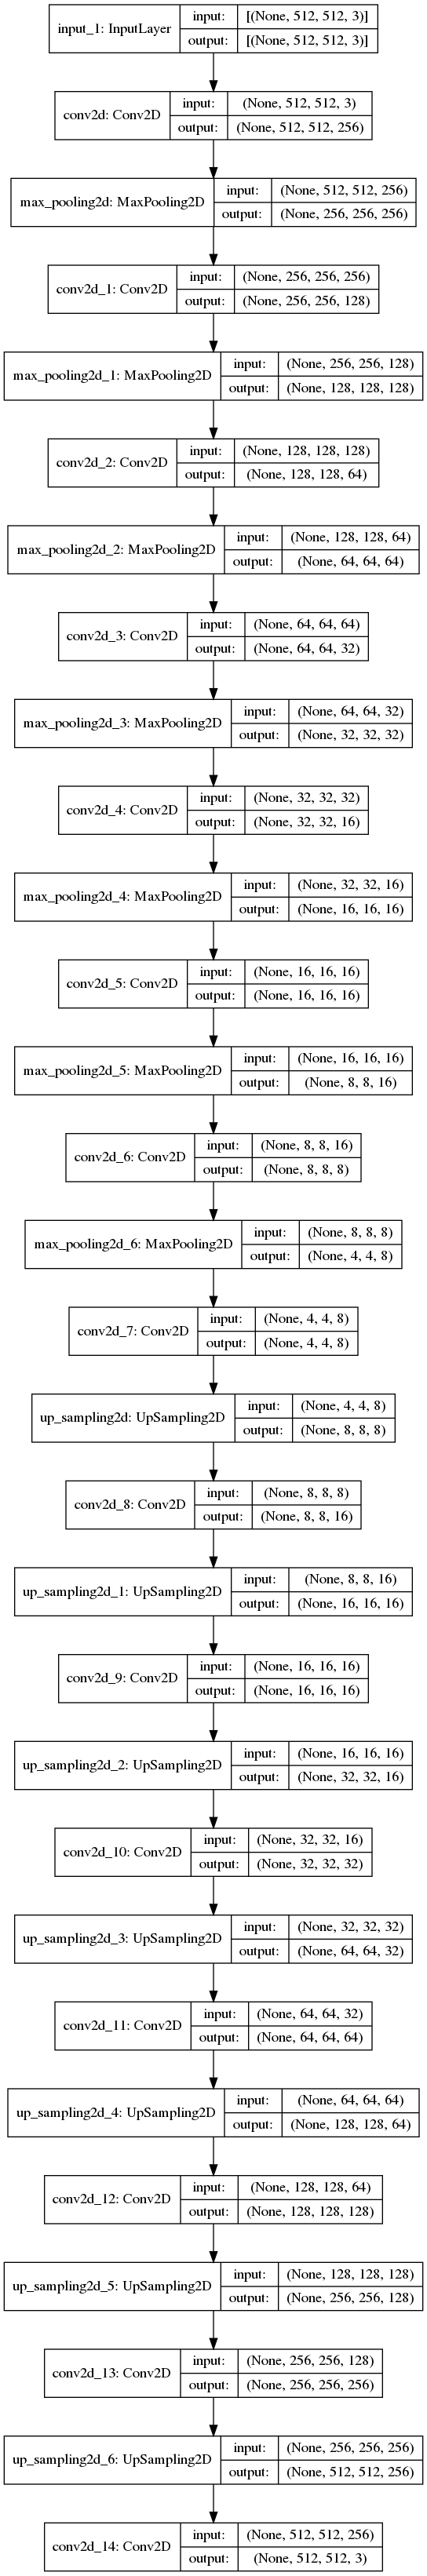

In [5]:
plot_model(autoencoder, show_shapes=True)

## Extracting Features from intermediate layers

In [7]:
intermediate_layer_model_1 = keras.Model(inputs=autoencoder.inputs,
                                      outputs=model.get_layer('max_pooling2d_1').output)
features_1 = intermediate_layer_model_1(train_images)
intermediate_layer_model_2 = keras.Model(inputs=autoencoder.inputs,
                                      outputs=model.get_layer('max_pooling2d_3').output)
features_2 = intermediate_layer_model_1(train_images)
intermediate_layer_model_3 = keras.Model(inputs=autoencoder.inputs,
                                      outputs=model.get_layer('max_pooling2d_5').output)
features_3 = intermediate_layer_model_1(train_images)

max_pooling2d_1
max_pooling2d_3
max_pooling2d_5


## Training and testing the model

In [ ]:
autoencoder.fit(train_images, train_images, epochs = 1, shuffle = True, verbose=1, validation_data=(val_images, val_images))

In [ ]:
decoded_imgs = autoencoder.predict(test_images)

## Comparing test and model created images

In [ ]:
n = 2
plt.figure(figsize=(32,32))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Visualizing loss

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()